### Index rules

This backtest shows the performance of a simple option strategy: a protective put on the S&P 500, partially financed with an out-of-the-money (OTM) call. The goal of this strategy is to mitigate drawdowns during periods of market stress while still providing upside exposure to the S&P 500.

Specifically, the strategy involves being long on IVV (an ETF that tracks the S&P 500), long on a 95 put option, and short on a 115 call option. The index is rebalanced on a quarterly basis. Please note that this analysis is a proof of concept, and certain approximations have been made due to limited data availability.

In [5]:
import math
from scipy.stats import norm
import pandas as pd
import os
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

from option_pricing import DataLoader
from option_pricing import BSEuropeanPut
from option_pricing import BSEuropeanCall


In [2]:
# loading Data
all_data = DataLoader()
vix, sofr, IVV, dates = all_data.vix, all_data.sofr, all_data.IVV, all_data.dates

[*********************100%***********************]  1 of 1 completed


In [16]:
# Backtest

# rebalance quarterly
rebal_dates = [dates[i] for i in range(len(dates)-1) if (((dates[i].month - dates[i + 1].month) != 0) & (dates[i].month in [3,6,9,12]))]
backtest_period = [date for date in dates if date <= datetime.date(2022,12,29)]

# initial portfolio
rebal = 0
inception_date = dates[0]
rebal_date = rebal_dates[rebal]
time_to_expiration = (rebal_date - inception_date).days / 365
dividend_yield = 0

# initial setup
implied_vol = all_data.get_vix_contract(vix, inception_date, time_to_expiration)
sofr_rate = sofr.loc[sofr["asofdate"] == inception_date, "Rate (%)"].values[0]/100
intial_underlying_asset = IVV.loc[IVV["asofdate"] == inception_date, "Adj Close" ].values[0]
strike_put = 0.95 * intial_underlying_asset
strike_call = 1.15 * intial_underlying_asset

# open option postions
book_cost_long_put = BSEuropeanPut(intial_underlying_asset, strike_put, sofr_rate, dividend_yield, time_to_expiration, implied_vol).price
book_cost_short_call = BSEuropeanCall(intial_underlying_asset, strike_call, sofr_rate, dividend_yield, time_to_expiration, implied_vol).price

# dictionaries to store results 
# historical protfolio value
dict_port =  {inception_date : intial_underlying_asset}
# historical costs to buy/sell options 
dict_cost_put = {inception_date: book_cost_long_put}
dict_cost_call = {inception_date: book_cost_short_call}
# historical payout at expiration: gains/losses of old options expiring ITM/OTM
dict_pl_put_at_expiration = {inception_date: 0}
dict_pl_call_at_expiration = {inception_date: 0}
# historical mkt value of options 
values_put = [book_cost_long_put]
values_call = [book_cost_short_call]

# backtest begins
for trade_date in backtest_period[1:]:
    
    # mkt data
    underlying = IVV.loc[IVV["asofdate"] == trade_date, "Adj Close" ].values[0]
    sofr_rate = sofr.loc[sofr["asofdate"] == trade_date, "Rate (%)"].values[0]/100

    # days that are not rebalance
    if trade_date not in rebal_dates:

        # open options  
        time_to_expiration = (rebal_date - trade_date).days / 365
        implied_vol = all_data.get_vix_contract(vix, trade_date, time_to_expiration)
        put = BSEuropeanPut(underlying, strike_put, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        call = BSEuropeanCall(underlying, strike_call, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        price_put = put.price
        price_call = call.price

        # value portfolio:
        port = (underlying + price_put - price_call 
                - sum(dict_cost_put.values()) + sum(dict_cost_call.values()) 
                + sum(dict_pl_put_at_expiration.values()) - sum(dict_pl_call_at_expiration.values()))
        dict_port[trade_date] = port

    elif trade_date in rebal_dates:    

        # positions expiring 
        time_to_expiration = 0.0001
        implied_vol = all_data.get_vix_contract(vix, trade_date, time_to_expiration)
        put = BSEuropeanPut(underlying, strike_put, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        call = BSEuropeanCall(underlying, strike_call, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        price_put = put.price
        price_call = call.price

        #saving final payout at expiration
        dict_pl_put_at_expiration[trade_date] = price_put
        dict_pl_call_at_expiration[trade_date] = price_call

        # new rebalance date
        rebal += 1
        rebal_date = rebal_dates[rebal]

        # resetting strike prices
        strike_put = 0.95 * underlying
        strike_call = 1.15 * underlying
        

        # new options bought/sold
        time_to_expiration = (rebal_date - trade_date).days / 365
        implied_vol = all_data.get_vix_contract(vix, trade_date, time_to_expiration)
        put = BSEuropeanPut(underlying, strike_put, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        call = BSEuropeanCall(underlying, strike_call, sofr_rate, dividend_yield, time_to_expiration, implied_vol)
        price_put = put.price
        price_call = call.price

        # recording the new book cost
        dict_cost_put[trade_date] = price_put
        dict_cost_call[trade_date] = price_call

        # new port value
        port = (underlying + price_put - price_call 
                - sum(dict_cost_put.values()) + sum(dict_cost_call.values()) 
                + sum(dict_pl_put_at_expiration.values()) - sum(dict_pl_call_at_expiration.values()))
        dict_port[trade_date] = port
    
#     print(trade_date, " - Next Rebal: ", rebal_date," SPY: ", 
#           round(underlying,3), " Port: ", round(port,4), "Low K: ", 
#           round(strike_put,2), "High K: ", round(strike_call,2),
#           "Vol: ", round(implied_vol, 3))


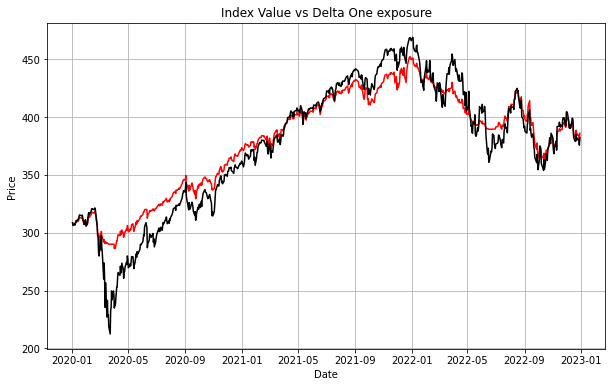

In [8]:
# Get output
index_start = pd.DataFrame([dict_port]).T
results = pd.merge(index_start,IVV["Adj Close"], left_index=True, right_index=True, how= "left")
results.columns = ["Custom Index", "IVV"]

# plotting
plt.figure(figsize=(10, 6))  
plt.plot(results.index, results["Custom Index"], color = 'red', linewidth=1.5 , label = "Custom Index" )
plt.plot(results.index, results["IVV"], color = 'black', linewidth=1.5 , label = "IVV" ) 
plt.title('Index Value vs Delta One exposure')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()